# Обучение модели YOLOv5






## ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

### Импорт репозитория

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


### Установка необходимых пакетов

In [ ]:
!pip install -r yolov5/requirements.txt

### Импрот необходимых модулей

In [4]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import tarfile

### Загрузка данных

In [5]:
# Загрузка датасета
data_dir = "../../0000_data/"
if not os.path.exists(f"{data_dir}VOCdevkit"):
    if not os.path.exists(f"{data_dir}VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", f"{data_dir}VOC.tar"
        )
    with tarfile.open(f"{data_dir}VOC.tar") as tar:
        tar.extractall()

### Конвертация аннотаций к формату YOLO v5


### Формат PASCAL VOC 
хранит свои аннотации в XML-файлах. Давайте посмотрим на один такой файл.

In [6]:
!type ..\..\0000_data\VOCdevkit\VOC2012\Annotations\2007_000027.xml 

<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000027.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>486</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>person</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>174</xmin>
			<ymin>101</ymin>
			<xmax>349</xmax>
			<ymax>351</ymax>
		</bndbox>
		<part>
			<name>head</name>
			<bndbox>
				<xmin>169</xmin>
				<ymin>104</ymin>
				<xmax>209</xmax>
				<ymax>146</ymax>
			</bndbox>
		</part>
		<part>
			<name>hand</name>
			<bndbox>
				<xmin>278</xmin>
				<ymin>210</ymin>
				<xmax>297</xmax>
				<ymax>233</ymax>
			</bndbox>
		</part>
		<part>
			<name>foot</name>
			<bndbox>
				<xmin>273</xmin>
				<ymin>333</ymin>
				<xmax>297</xmax>
				<ymax>354</ymax>
			</bndbox>
		</part>
		<part>
			<name>foot<

Данная аннотация относится к файлу 2007_000027.jpg размером 486х500х3. Файл содерит один тэг object, описывающий класс объекта и координаты ограничивающих рамок. Класс определяется тегом name. Рамка тегами - xmin, ymin, xmax, ymax. Соответственно верхний левый угол рамки (xmin, ymin) и нижний правый (xmax, ymax). Четыре тега part описывают рамки частей объекта.

### Формат YOLO v5 
подразумевает аннотацию для каждого изображения в виде файла .txt (имя файл совпадает с именем изображения), где каждая строка текстового файла описывает ограничивающую рамку. Рассмотрим следующее изображение.

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)




Файл аннотаций zidane.txt для приведенного выше изображения выглядит следующим образом:

```
27 0.786719 0.502778 0.0328125 0.161111 0.287125
0 0.471875 0.629167 0.765625 0.713889 0.593856
0 0.741406 0.522222 0.310937 0.925 0.877349
```
Описано три объекта. Спецификация для каждой строки выглядит следующим образом:

* Одна строка на объект
* Каждая строка имеет формат class x_center y_center width height.
* Координаты нормализованы по относительно размера изображения
* Индексация классов начинается с нуля

Структура каталогов набора данных формата YOLOv5
```
base_dir
├── images           # изображения
│   ├── test
│   ├── train
│   └── validation
└── labels           # аннотации
    ├── test
    ├── train
    └── validation
```    


### Подготовка к преобразованию данных

In [43]:

def extract_info_from_xml(xml_file):
    
    '''
        Извлекает описание объектов из формата XML и преобразует данные в словарь
    '''
    root = ET.parse(xml_file).getroot()
    
    # инициализация словаря
    info_dict = {}
    info_dict['bboxes'] = []

    # парсинг XML
    for elem in root:
        # получение имени файла
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # получение размера файла
        elif elem.tag == "size":
            image_size = [-1,-1,-1]
            for subelem in elem:
                if subelem.tag == "width":
                    image_size[0] = int(subelem.text)
                if subelem.tag == "height":
                    image_size[1] = int(subelem.text)
                if subelem.tag == "depth":
                    image_size[2] = int(subelem.text)
            
            info_dict['image_size'] = tuple(image_size)
        
        # получение описания рамок
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(float(subsubelem.text))            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [44]:
extract_info_from_xml("../../0000_data/VOCdevkit/VOC2012/Annotations/2011_003300.xml")


{'bboxes': [{'class': 'person',
   'xmax': 264,
   'xmin': 71,
   'ymax': 302,
   'ymin': 8}],
 'filename': '2011_003300.jpg',
 'image_size': (500, 375, 3)}

In [88]:
# получение словаря объектов для отображения имени на идентификатор
annotations_dir = '../../0000_data/VOCdevkit/VOC2012/Annotations2'
a = [os.path.join(annotations_dir, x) for x in os.listdir(annotations_dir) if x[-3:] == "xml"]
a = [extract_info_from_xml(x) for x in a] 
a = [x["bboxes"] for x in  a]
a = [[z["class"] for z in x] for x in a]
a = set(sum(a, []))
class_name_to_id_mapping = {x: i for (i, x) in enumerate(a)}

class_name_to_id_mapping


{'cow': 0,
 'bus': 1,
 'horse': 2,
 'cat': 3,
 'motorbike': 4,
 'sofa': 5,
 'tvmonitor': 6,
 'person': 7,
 'bicycle': 8,
 'diningtable': 9,
 'aeroplane': 10,
 'sheep': 11,
 'boat': 12,
 'bird': 13,
 'train': 14,
 'dog': 15,
 'bottle': 16,
 'chair': 17,
 'car': 18,
 'pottedplant': 19}

In [75]:
# Преобразуйте info dict в требуемый формат yolo и запишите его на диск
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_dir, info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [90]:
# Get the annotations
annotations = [os.path.join(annotations_dir, x) for x in os.listdir(annotations_dir) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(annotations_dir, x) for x in os.listdir(annotations_dir) if x[-3:] == "txt"]
# annotations

100%|██████████| 235/235 [00:00<00:00, 1383.07it/s]


Тестирование аннотаций
Просто для проверки здравомыслия давайте теперь протестируем некоторые из этих преобразованных аннотаций. Мы случайным образом загружаем одно из полей аннотаций и графиков, используя преобразованные аннотации, и визуально проверяем его, чтобы увидеть, сработал ли наш код так, как предполагалось.

Запустите следующую ячейку несколько раз. Каждый раз выбирается случайная аннотация.

../../0000_data/VOCdevkit/VOC2012/Annotations2\2007_001340.txt
[[15.0, 0.826, 0.879, 0.348, 0.243], [17.0, 0.619, 0.419, 0.386, 0.581], [7.0, 0.402, 0.687, 0.204, 0.627], [7.0, 0.423, 0.647, 0.478, 0.701]]


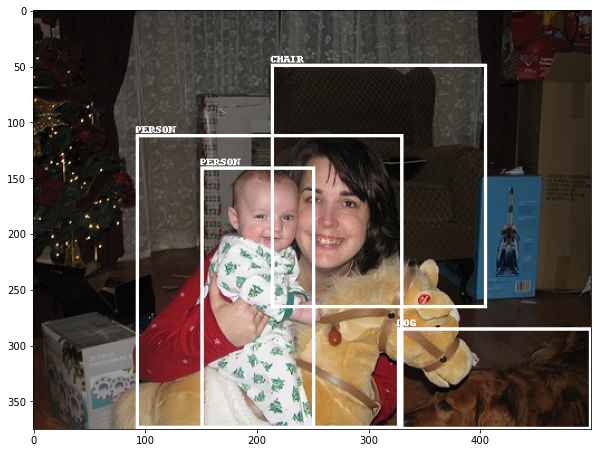

In [94]:
# random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), width=3)
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))].upper())
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(image), aspect=1)
    # plt.imshow(np.array(image), origin='lower', extent=[-4, 4, -1, 1], aspect=10)
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
print(annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
print(annotation_list)
#Get the corresponding image file
image_file = annotation_file.replace("Annotations2", "JPEGImages").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)